In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [119]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect,desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)



In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station=Base.classes.station
measurement=Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
Base.classes.station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [10]:
Base.classes.measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [11]:
inspector = inspect(engine)
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [12]:
# Find the most recent date in the data set.
most_recent=session.query(measurement).order_by(measurement.date.desc()).first()
most_recent.date

'2017-08-23'

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago=pd.to_datetime(most_recent.date)-timedelta(days=366)
year_ago=str(year_ago)[:10]

# Perform a query to retrieve the data and precipitation scores
one_year_prcp = session.query(measurement.date,measurement.prcp).\
filter(measurement.date>year_ago).order_by(measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df=pd.DataFrame(one_year_prcp,columns=['Date','precipitation']).set_index('Date').sort_index()
prcp_df.head()






,precipitation
Date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,NaN


['2016-08-23',
 '2016-10-01',
 '2016-11-09',
 '2016-12-19',
 '2017-01-28',
 '2017-03-09',
 '2017-04-18',
 '2017-05-31',
 '2017-07-10']

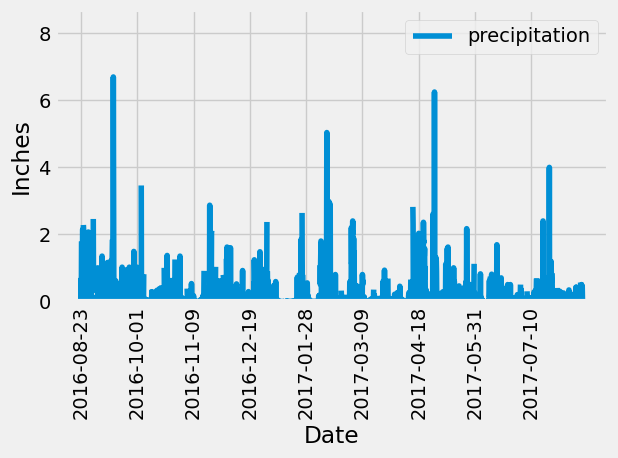

In [90]:
#find xthick locations/labels
step=int(round(len(prcp_df)/9, -1))
tick_locations = [i*step for i in range(0,9)]
labels=[]
for i in range(0,9):
    labels.append(prcp_df.index[i*step])

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()
plt.ylabel("Inches")
plt.ylim(0,max(prcp_df['precipitation']+2))
plt.xticks(ticks=tick_locations,labels=labels,rotation="vertical")
plt.tight_layout()
plt.show()


In [91]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [105]:
# Design a query to calculate the total number stations in the dataset
session.query(measurement.station).distinct().count()

9

In [126]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
measurement_rows=session.query(measurement.station,func.count(measurement.id).\
                               label('number')).group_by(measurement.station).order_by(desc('number'))

most_active_station=measurement_rows.first()[0]
print (f"*** The most active station is {most_active_station} ***")

for measurement_row in measurement_rows:
    print("-"*12)
    print(f"station: {measurement_row.station}  number: {measurement_row.number}")



*** The most active station is USC00519281 ***
------------
station: USC00519281  number: 2772
------------
station: USC00519397  number: 2724
------------
station: USC00513117  number: 2709
------------
station: USC00519523  number: 2669
------------
station: USC00516128  number: 2612
------------
station: USC00514830  number: 2202
------------
station: USC00511918  number: 1979
------------
station: USC00517948  number: 1372
------------
station: USC00518838  number: 511


In [138]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_stats=session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
            filter(measurement.station==most_active_station)

                               
print(f"The lowest temperature for station {most_active_station} is {temperature_stats[0][0]}")
print("-"*30)
print(f"The highest temperature for station {most_active_station} is {temperature_stats[0][1]}")
print("-"*30)
print(f"The average temperature for station {most_active_station} is {round(temperature_stats[0][2],2)}")
print("-"*30)

The lowest temperature for station USC00519281 is 54.0
------------------------------
The highest temperature for station USC00519281 is 85.0
------------------------------
The average temperature for station USC00519281 is 71.66
------------------------------


In [142]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date one year from the last date in data set.
year_ago=pd.to_datetime(most_recent.date)-timedelta(days=366)
year_ago=str(year_ago)[:10]

# Perform a query to retrieve the date and temperature for the most active station
one_year_tobs = session.query(measurement.date,measurement.tobs).\
filter(measurement.date>year_ago).filter(measurement.station==most_active_station).all()

tobs_df=pd.DataFrame(one_year_tobs,columns=['Date','Temperature']).set_index('Date').sort_index()
tobs_df.head()

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


<AxesSubplot:ylabel='Frequency'>

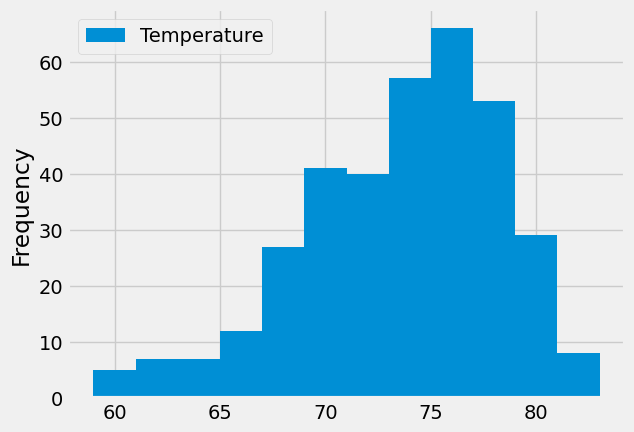

In [143]:
tobs_df.plot.hist(bins=12)

# Close session

In [80]:
# Close Session
session.close()